# Japan Deflation Analysis

- https://www.boj.or.jp/statistics/money/ms/index.htm/ (Single Data)
- https://www.e-stat.go.jp/statistics-by-theme/ (Multiple Data)
- https://www.boj.or.jp/statistics/index.htm/ (Multiple Data)
- https://data.worldbank.org/indicator (Multiple Data)
- https://stats.oecd.org/# (Multiple Data) Use this 

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# visualization
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

sns.set(color_codes=True)

In [2]:
def transform_dataset(data):
    data = data.set_index('Unnamed: 0')
    data.index.rename('', inplace=True)
    return data

In [3]:
# import relevant dataset
full_data = pd.read_csv('data/full_data.csv')
economic_index = pd.read_csv('data/ei_combined.csv')
cpi_index = pd.read_csv('data/cpi_index.csv')
gdp_production_index = pd.read_csv('data/gdp_production_index.csv')
health_index = pd.read_csv('data/health_index.csv')
population_index = pd.read_csv('data/population_index.csv')
ppp_index = pd.read_csv('data/ppp_index.csv')
productivity_ulc_index = pd.read_csv('data/productivity_ulc_index.csv')

# transform relevant dataset
full_data = transform_dataset(full_data)
economic_index = transform_dataset(economic_index)
cpi_index = transform_dataset(cpi_index)
gdp_production_index = transform_dataset(gdp_production_index)
health_index = transform_dataset(health_index)
population_index = transform_dataset(population_index)
ppp_index = transform_dataset(ppp_index)
productivity_ulc_index = transform_dataset(productivity_ulc_index)

population_index = population_index.drop(columns=['89'])

## Introduction

In [4]:
cpi_history = pd.read_csv('data/cpi.csv')
oecd_cpi = cpi_index['CPI: 01-12 - All items']

In [5]:
cpi_history = cpi_history.loc[cpi_history['Subject'] == 'CPI: 01-12 - All items'][['Country', 'Time', 'Value']]
cpi_japan = cpi_history.loc[cpi_history['Country'] == 'Japan']
cpi_world = cpi_history.loc[cpi_history['Country'] != 'Japan']

In [6]:
time_series = cpi_world['Time'].unique()
avg_cpi = []

for time in time_series:
    avg_cpi.append(cpi_world.loc[cpi_world['Time'] == time]['Value'].mean())

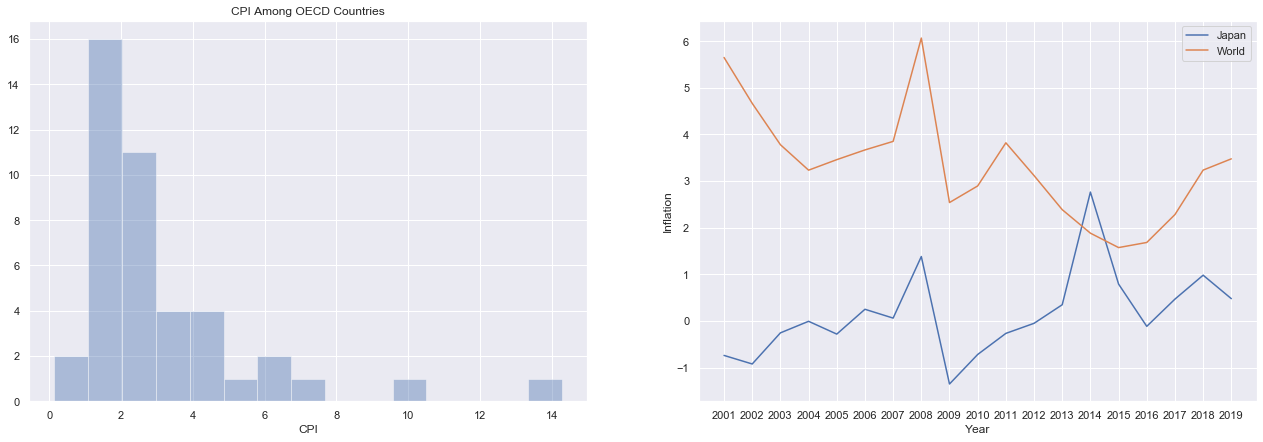

In [7]:
plt.figure(figsize = (22, 7))

plt.subplot(1, 2, 1)
sns.distplot(oecd_cpi.values, kde=False)
plt.xlabel('CPI')
plt.title('CPI Among OECD Countries')

plt.subplot(1, 2, 2)
plt.plot(cpi_japan['Time'], cpi_japan['Value'], label="Japan")
plt.plot(cpi_japan['Time'], avg_cpi, label="World")
plt.xticks(range(2001, 2020, 1))
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.show()

## Finding similar countries to Japan

In this section we use t-SNE on the dataset to create a scatter plot, and find the countries that are close to Japan in terms of the distance between coordinates on the scatter plot.

### Principal Component Analysis (PCA)

In [8]:
data_reduced = PCA(n_components=2).fit_transform(full_data)

In [9]:
japan = data_reduced[22]
others = np.delete(data_reduced, 22, axis=0)

country_data = [x for x in full_data.index if x != 'Japan']

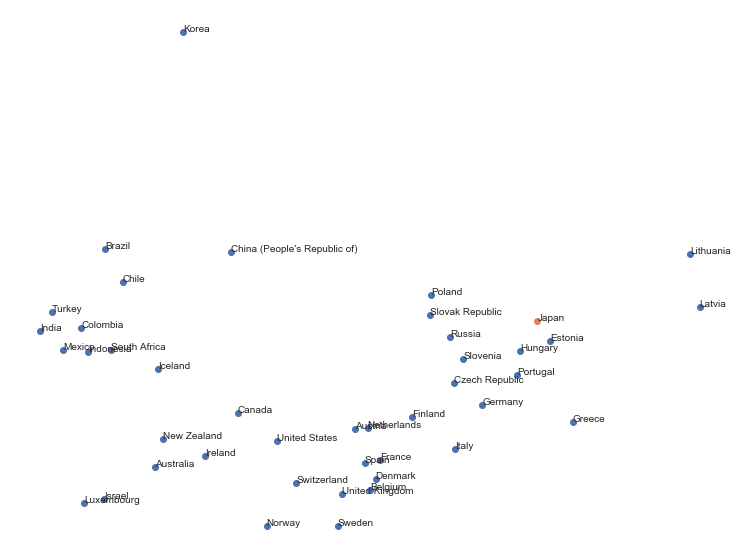

In [10]:
# plot scatter graph
plt.figure(figsize=(13,10))
plt.scatter(others[:, 0], others[:, 1])
plt.scatter(japan[0], japan[1])

for i, txt in enumerate(country_data):
    plt.annotate(txt, (others[:, 0][i], others[:, 1][i]))
    
plt.annotate("Japan", (japan[0], japan[1]))
plt.axis('off')
plt.show()

By visualizing the data obtained from t-SNE we can plot the scatter plot above. Japan is depicted as the orange point and all the other countries are shown with a blue point. To find the closest countries to Japan in terms of coordinates, we find the distance between coordinates measuring the euclidean distance.

In [11]:
euclidean_distance = []

for data in data_reduced:
    # get euclidean distance
    euclidean_distance.append(np.linalg.norm(data - japan))
    
eucli_dist_arr = list(zip(full_data.index, euclidean_distance))
ordered_arr = sorted(eucli_dist_arr, key = lambda entry: entry[1])

for i in range(1, 11, 1):
    print("{}: {}".format(i, ordered_arr[i][0]))

1: Estonia
2: Hungary
3: Portugal
4: Russia
5: Slovenia
6: Slovak Republic
7: Poland
8: Czech Republic
9: Germany
10: Greece


The ranking above shows the 10 closest countries to Japan show in the PCA scatter plot. To get a further understanding into the similarities and difference between the 10 countries and Japan, we look into the social factors to get more insight.

## Comparing Social Factors

In this section, similar to the previous section, we use t-SNE to create visualizations for each social factors to identify the areas in which Japan shows similarities with the other four countries.

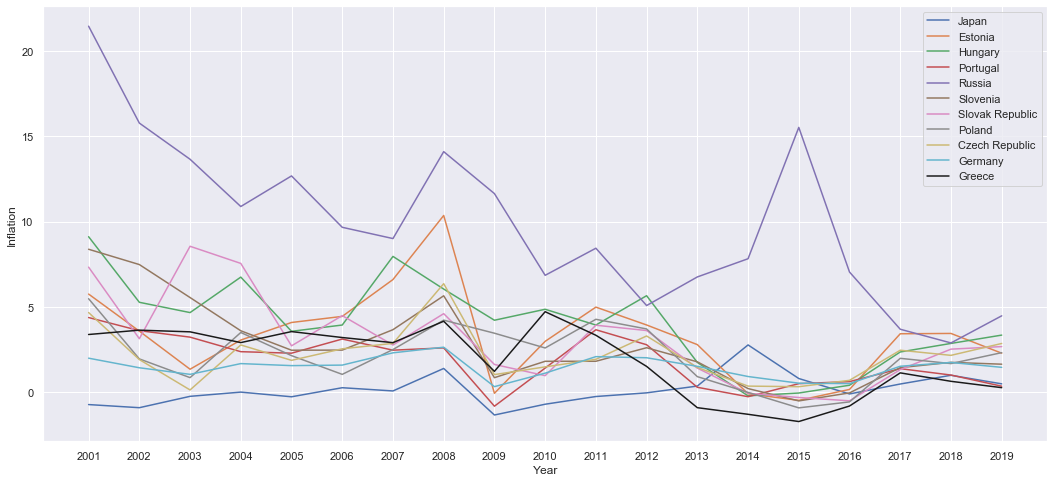

In [12]:
cpi_estonia = cpi_history.loc[cpi_history['Country'] == 'Estonia']
cpi_hungary = cpi_history.loc[cpi_history['Country'] == 'Hungary']
cpi_portugal = cpi_history.loc[cpi_history['Country'] == 'Portugal']
cpi_russia = cpi_history.loc[cpi_history['Country'] == 'Russia']
cpi_slovenia = cpi_history.loc[cpi_history['Country'] == 'Slovenia']
cpi_slovak = cpi_history.loc[cpi_history['Country'] == 'Slovak Republic']
cpi_poland = cpi_history.loc[cpi_history['Country'] == 'Poland']
cpi_czech = cpi_history.loc[cpi_history['Country'] == 'Czech Republic']
cpi_germany = cpi_history.loc[cpi_history['Country'] == 'Germany']
cpi_greece = cpi_history.loc[cpi_history['Country'] == 'Greece']

cpi_countries = [cpi_japan, cpi_estonia, cpi_hungary, cpi_portugal, cpi_russia, cpi_slovenia, cpi_slovak, cpi_poland,
                cpi_czech, cpi_germany, cpi_greece]

plt.figure(figsize=(18, 8))
for countries in cpi_countries:
    if countries is not cpi_greece:
        plt.plot(cpi_japan['Time'], countries['Value'], label=countries['Country'].unique()[0])
    else:
        plt.plot(cpi_japan['Time'], countries['Value'], 'k', label=countries['Country'].unique()[0])
plt.xticks(range(2001, 2020, 1))
plt.xlabel('Year')
plt.ylabel('Inflation')
plt.legend()
plt.show()

In [13]:
def create_standarized_dataset(data):
    """
    """
    # create pipeline
    data_copy = data.copy()
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler())
    ])
    transformed_data = num_pipeline.fit_transform(data_copy)
    
    data_copy[:] = transformed_data
    return data_copy

In [14]:
def get_top_10(data):
    """
    """
    return data.loc[
        (data.index == 'Estonia') |
        (data.index == 'Hungary') |
        (data.index == 'Portugal')|
        (data.index == 'Russia') |
        (data.index == 'Slovenia') |
        (data.index == 'Slovak Republic') |
        (data.index == 'Poland') |
        (data.index == 'Czech Republic') |
        (data.index == 'Germany') |
        (data.index == 'Greece') |
        (data.index == 'Japan')
    ]

Next we count the number of NaN values in the data frame.

In [15]:
data_label = [("Economic Index", economic_index), ("CPI", cpi_index), ("GDP Production", gdp_production_index), 
                ("Health", health_index), ("Productivity", productivity_ulc_index), ("Population", population_index)]

for datum in data_label:
    print(datum[0])
    print(datum[1].isna().sum())
    print('\n')
    print("Length of dataset", len(datum[1]))
    print('\n')
    print('\n')

Economic Index
Exports in goods, s.a.                                                 0
Imports in goods, s.a.                                                 0
Share prices                                                           0
Consumer prices: all items                                             0
Industrial production, s.a.                                            3
Permits issued for dwellings, s.a.                                    13
Passenger car registrations, s.a.                                      7
Retail trade (Volume), s.a.                                            4
Gross domestic product; constant prices, s.a.                          0
GDP Private final consumption expenditure; constant prices, s.a.       1
GDP Government consumption expenditure; constant prices, s.a.          1
GDP Gross fixed capital formation; constant prices, s.a.               1
GDP Exports; constant prices, s.a.                                     1
GDP Imports of goods and services; c

From the output above, the economic index and productivity dataset has relatively large amount of missing data. For productivity some columns have almost half the data missing. Furthermore, we can also see that the health data has also some missing values as well. The other datasets have small amounts of missing data.

We then drop columns that have more than 10 missing data as substuting missing data in the dataset can cause the dimension reduction to become inaccurate.

In [16]:
ei_columns_drop = [
    'Permits issued for dwellings, s.a.',
    'Hourly earnings: manufacturing, s.a.',
    'Broad money, s.a.',
    'Unit labour cost: Total Economy, s.a.'
]

health_columns_drop = [
    'Ancillary services (non-specified by function)',
    'Other health care services unknown'
]

productivity_columns_drop = [
    'Capital deepening',
    'Total capital services',
    'Multifactor productivity',
    'ICT capital deepening',
    'Capital productivity',
    'ICT capital',
    'Non-ICT capital deepening',
    'Non-ICT capital'
]

economic_index = economic_index.drop(columns=ei_columns_drop)
health_index = health_index.drop(columns=health_columns_drop)
productivity_ulc_index = productivity_ulc_index.drop(columns=productivity_columns_drop)

In [18]:
# create data frame with relevant countries
ei_10 = get_top_10(create_standarized_dataset(economic_index))
cpi_10 = get_top_10(create_standarized_dataset(cpi_index))
gdp_production_10 = get_top_10(create_standarized_dataset(gdp_production_index))
health_10 = get_top_10(create_standarized_dataset(health_index))
ppp_10 = get_top_10(create_standarized_dataset(ppp_index))
productivity_ulc_10 = get_top_10(create_standarized_dataset(productivity_ulc_index))
population_10 = get_top_10(create_standarized_dataset(population_index))

In [19]:
pca = PCA(n_components=2)

ei_reduced = pca.fit_transform(ei_10)
cpi_reduced = pca.fit_transform(cpi_10)
gdp_production_reduced = pca.fit_transform(gdp_production_10)
health_reduced = pca.fit_transform(health_10)
productivity_ulc_reduced = pca.fit_transform(productivity_ulc_10)
population_reduced = pca.fit_transform(population_10)

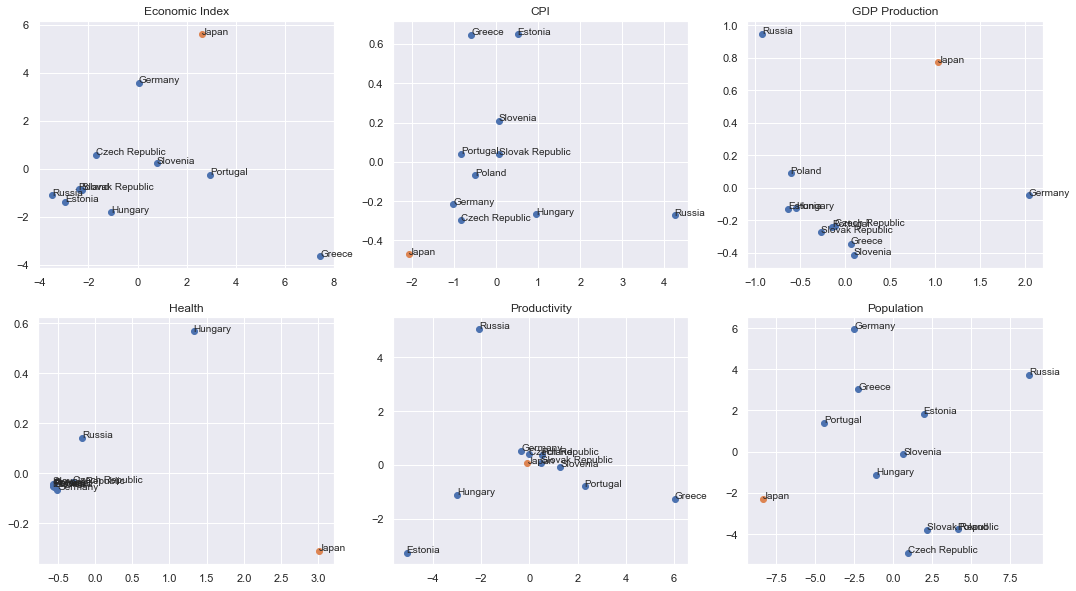

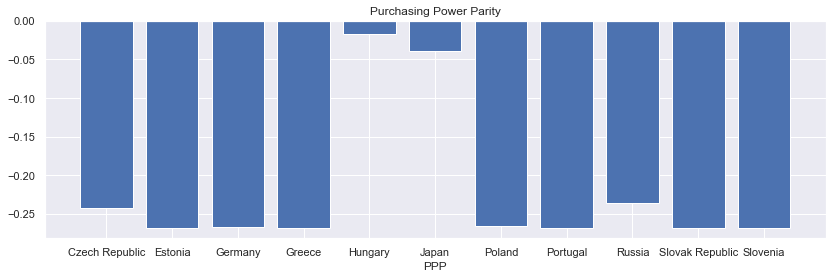

In [20]:
plt.figure(figsize=(18, 10))

index = 1
reduced_data = [("Economic Index", ei_reduced), ("CPI", cpi_reduced), ("GDP Production", gdp_production_reduced), 
                ("Health", health_reduced), ("Productivity", productivity_ulc_reduced), ("Population", population_reduced)]
for title, data in reduced_data:
    plt.subplot(2, 3, index)
    
    japan = data[5]
    others = np.delete(data, 5, 0)
    
    plt.scatter(others[:, 0], others[:, 1])
    plt.scatter(japan[0], japan[1])

    country_data = [x for x in ei_10.index if x != 'Japan']
    for i, txt in enumerate(country_data):
        plt.annotate(txt, (others[:, 0][i], others[:, 1][i]))
    plt.annotate("Japan", (japan[0], japan[1]))
    plt.title(title)
    
    index += 1
plt.show()

plt.figure(figsize=(14, 4))
plt.title('Purchasing Power Parity')
plt.xlabel('PPP')
plt.bar([x for x in ppp_10.index], np.ndarray.flatten(ppp_10.values))
plt.show()

From the scatter plots we can deduce the following information:

- Japan is similiar to the other 10 countries in terms of productivity
- Japan is not similar to the other 10 countries in terms of Health, GDP Production, and PPP
- For Economic index and population, we moderate differences between Japan and the 10 contries.

Now we look into each category to see the similarities and differences between the sub-categories.

### CPI

In [25]:
get_top_10(cpi_index)

,CPI: 01-12 - All items,CPI: 01 - Food and non-Alcoholic beverages,CPI: Energy,CPI: All items non-food non-energy
,,,,
Czech Republic,2.156178,2.160546,2.866108,1.165886
Estonia,3.287096,3.886372,5.983029,2.449235
Germany,1.461101,1.864408,2.861249,1.280492
Greece,1.851626,1.895024,5.152795,1.461957
Hungary,4.016100,4.821159,4.155697,3.749147
Japan,0.146885,0.718566,1.560671,-0.101282
Poland,2.154386,2.746930,3.604190,1.579270
Portugal,1.829863,1.369012,3.547424,1.812112
Russia,9.867767,9.180149,6.629792,6.501875


We see that on average Japan has by far the lowest CPI value among the 10 countries. Through 2001 to 2019, Japan's average CPI was 0.147% while the second lowest was Germany with 1.461%. The second and third columns shows us that CPI for food and non-alcohol beverages and energy is higher than the CPI for all items. However, the last column - CPI for all non-food and non-energy items- is very low. Therefore we can see that the low CPI on the prices of goods is preventing the CPI from increasing.

### Productivity

In [32]:
get_top_10(productivity_ulc_index)

,"GDP per hour worked, constant prices",Average hours worked per person employed,Total employment (number of persons employed),"GDP per person employed, constant prices","GDP per capita, constant prices",Total hours worked,Labour utilisation (=hours worked per head of population),Unit Labour Costs,Labour compensation per hour worked,Labour compensation per employee,"Unit Labour Costs, employment based","Unit Labour Costs, employment based, USD exchange-rate adjusted","Unit Labour Costs, USD exchange-rate adjusted",Capital quality,Total capital stock
,,,,,,,,,,,,,,,
Czech Republic,50.549566,49.631093,50.642190,50.133075,51.185435,50.260454,50.581144,51.072897,52.091079,51.848919,51.221048,58.393685,58.191734,NaN,NaN
Estonia,48.954598,50.870650,56.137224,50.106835,56.290317,56.906394,56.766409,52.247060,53.851944,53.937290,52.283724,58.463843,58.420643,NaN,NaN
Germany,51.273457,49.700432,50.966328,50.939629,51.222313,50.628181,49.893379,51.558881,53.004647,52.813542,51.765027,57.609844,57.392328,50.139249,50.129326
Greece,48.579588,51.181809,46.853022,49.584335,47.379648,47.999225,48.748720,45.184873,43.885551,44.257544,44.590570,50.189928,50.786421,48.614149,46.477333
Hungary,49.816328,50.253350,53.639937,49.913614,53.893786,53.901749,54.176728,51.732823,52.212232,52.379900,51.955633,63.134742,62.948367,NaN,NaN
Japan,50.197335,50.290136,50.600920,50.490808,51.383312,50.732300,50.963159,51.130748,51.201911,51.479598,51.118162,59.204791,59.224080,49.943376,49.645596
Poland,50.672593,50.086548,49.842750,51.525486,51.961906,49.716896,49.927369,50.125614,52.319097,52.099768,49.973518,56.695816,56.866610,NaN,NaN
Portugal,49.509432,49.730461,50.049218,49.422316,49.999874,49.730024,50.293371,48.403625,48.306295,47.824592,48.279380,54.067272,54.198005,49.609856,47.987513
Russia,49.116709,50.187316,50.401225,49.288956,49.322657,50.547707,49.988542,50.690512,60.527872,60.618502,50.686698,86.492128,86.495961,NaN,NaN


### GDP Production

In [31]:
get_top_10(gdp_production_index)

,Gross Domestic Product (GDP); millions,GDP per head of population,GDP per hour worked,GDP per person employed
,,,,
Czech Republic,2.983312e+05,28508.055581,32.508073,58144.373383
Estonia,3.153341e+04,23665.998462,27.174271,51250.112602
Germany,3.339111e+06,40989.622751,56.253374,79721.868928
Greece,2.966757e+05,27125.547056,33.815393,67459.120978
Hungary,2.209213e+05,22225.327262,29.439973,52222.170842
Japan,4.515240e+06,35448.689094,38.774981,68223.444759
Poland,8.028952e+05,20920.863079,27.507058,51960.398046
Portugal,2.802723e+05,26854.741332,32.927712,57774.725118
Russia,2.838925e+06,19642.938723,20.290675,40228.617400
